# Trust regions in non linear optimization

This notebook uses trust regions to minimize non linear functions.

I implemented Powell's dog leg solver to calculate the direction to take in each consecutive iteration. 

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.optimize import minimize

The entire implementation can be done using the minimize function from the SciPy library, but I will implement the process and the model function as well.

Just as an example of the library the next cell uses the minimize function.

In [216]:
def fun_scipy(x):   
    return x[0]**2 + x[1]**2

def derivative(x):
    return np.array([ 2*x[0], 2*x[1]])

def hessian(x):
    return np.array([
        [2,   0],
        [0,   2]
    ])

x0 = np.array([-15.0, 23.0])

result = minimize(
    fun_scipy,
    x0,
    method="trust-ncg", # This attribute does the same as the code from the rest of the notebook
    jac=derivative,
    hess=hessian
)

print(result.x)

[0. 0.]


In [217]:
# Powell's dog leg trust-region solver
def model(g, B, delta):
    """
    Define the model

    Powell's dog leg algorithm obtains points by three cases:
        · The Cauchy point or steepest descent 
        · The Newton step 
        · The meeting point between the two inside the trust region

    The third point comes from when the process calculates first inside 
    the region, then outside and finally the middle, which assigns the point
    to the edge of the region. The dog leg name comes from obtaining this point 
    by adding the Cauchy point and the edge point, which gives two lines in a turn

    Parameters:
    g : jacobian matrix (array)
    B : hessian matrix (array)
    delta : radius of the trust region (int)

    Returns:
    the next point
    """
    # Cauchy point (steepest descent)
    gBg = g @ (B @ g)
    alpha_sd = (g @ g) / gBg
    p_sd = -alpha_sd * g

    # Newton step
    p_newton = -np.linalg.solve(B, g)

    # Check if the Newton step is inside the region
    if np.linalg.norm(p_newton) <= delta:
        return p_newton

    # Check if the Cauchy point is outside of the region
    if np.linalg.norm(p_sd) >= delta:
        return p_sd / np.linalg.norm(p_sd) * delta

    # If not any of those, intersect the two points with the edge of the 
    # region to get the new point
    p_diff = p_newton - p_sd  # point difference
    a = p_diff @ p_diff  # squared 
    b = 2 * (p_sd @ p_diff) # solve the quadratic function
    c = p_sd @ p_sd - delta**2

    tau = (-b + np.sqrt(b*b - 4*a*c)) / (2*a)
    return p_sd + tau * p_diff

# Trust-region algorithm
def trust_region(f, grad, hess, x0, delta0=1.0) -> dict: 
    """
    The algorithm

    Parameters:
    f : the function (function)
    grad : jacobian or the gradient (array)
    hess : hessian (array)
    x0 : the starting point (array)
    delta0 : the starting radius (int)

    Returns:
    dictionary
    Found_minimum : minimum point found (array)
    Path : history of the points (array)
    Regions : history of the deltas (array)
    """
    x = x0.copy()  # save current point
    delta = delta0 # and the delta (or radius)
    eta = 0.15     # aceptance threshold
    history = [x.copy()] # this is for plotting later 
    deltas = [delta] # this one as well

    for k in range(100): # 100 is the number of computations, can change
        g = grad(x) # load the derivative
        B = hess(x) # and the hessian

        # Solve trust-region subproblem
        p = model(g, B, delta)

        # Actual reduction
        f_old = f(x)  # store the current step before the next
        # predicted reduction
        pred = -(g @ p + 0.5 * p @ (B @ p))  # m(0) - m(p) = -(g @ p + 0.5 * p @ (B @ p))

        if pred <= 0:
            delta *= 0.25 #  If pred <= 0 there is no improvement so shrink the delta by 25%
            continue      #  and compute another with a smaller trust region

        rho = (f_old - f(x + p)) / pred  # ratio of the true reduction to predicted reduction
        #                                  to check the model's performance

        # Update the radius based on the ratio
        if rho < 0.25:
            delta *= 0.25
        else:
            if rho > 0.75 and np.linalg.norm(p) > 0.8 * delta: # check how far the step went 
                delta = min(2*delta, 10.0) #  and if it went really close to the border then 
                # increase the delta (with a maximum arbitrary increase of 10)

        if rho > eta:  # if the ratio goes above the threshold then we take 
            x = x + p  # the step without changes
            history.append(x.copy()) # save the path
            deltas.append(delta) # and save the delta
            
        if np.linalg.norm(g) < 1e-6: # if the point is at the minimum (or really close)
            print("x: ", x[0], "y: ", x[1]) # then the algorithm is done.
            break 

    return {"Found minimum" : x, "Path" : np.array(history), "Regions" : np.array(deltas)}



In [218]:
def plot_3d(f, history, x_range=(-3, 3), y_range=(-3, 3)):
    """
    Function to plot the 3d mesh of the function and the path taken
    It doesnt show the regions, another function will do that later
    """
    X = np.linspace(*x_range, 200)
    Y = np.linspace(*y_range, 200)
    X, Y = np.meshgrid(X, Y)
    Z = f(np.array([X, Y]))

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, alpha=0.4)

    xs = history[:, 0]
    ys = history[:, 1]
    zs = f(history.T)

    ax.plot(xs, ys, zs, color='red', marker='o', markersize = 3, linewidth=1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")

    plt.show()


In [219]:
def plot_trust_regions(f, history, deltas, x_range=(-3,3), y_range=(-3,3), levels=40):
    """
    Function to plot the trust regions

    It shows the path taken as well as the regions that 
    each point used to calculate the next point
    """
    X = np.linspace(*x_range, 400)
    Y = np.linspace(*y_range, 400)
    X, Y = np.meshgrid(X, Y)
    Z = f(np.array([X, Y]))
    x_final, y_final = history[-1]

    fig, ax = plt.subplots(figsize=(8,7))
    CS = ax.contour(X, Y, Z, levels=levels)
    ax.clabel(CS, inline=1, fontsize=8)

    xs = history[:, 0]
    ys = history[:, 1]
    ax.plot(xs, ys, 'ro-', linewidth=2, markersize=4, label="Path")
    
    ax.plot(x_final, y_final, 'go', markersize=12, label="Final minimum")

    for (x, y), delta in zip(history, deltas):
        circle = Circle((x, y), delta, color='blue', alpha=0.1)
        ax.add_patch(circle)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    plt.show()


In [220]:
def fun(x):   
    return x[0]**2 + x[1]**2

def derivative_fun(x):
    return np.array([ 2*x[0], 2*x[1]])

def hessian_fun(x):
    return np.array([
        [2,   0],
        [0,   2]
    ])

In [221]:
def fun2(x):   
    return 5*x[0]**2*x[1]**2 + (1 - 3*x[0]**2)**2 + 2*x[1]**4

def derivative_fun2(x):
    return np.array([
        36*x[0]**3 - 12*x[0] + 10*x[0]*x[1]**2,
        10*x[0]**2*x[1] + 8*x[1]**3
    ])

def hessian_fun2(x):
    return np.array([
        [108*x[0]**2 - 12 + 10*x[1]**2,   20*x[0]*x[1]],
        [ 20*x[0]*x[1], 10*x[0]**2 + 24*x[1]**2]
    ])

In [222]:
def fun3(X):
    x, y = X
    return (y - 0.2*x**2)**2 + 0.5*x**2

def derivative_fun3(X):
    x, y = X
    return np.array([
        -0.8*x*(y - 0.2*x**2) + x,
        2*(y - 0.2*x**2)
    ])

def hessian_fun3(X):
    x, y = X
    return np.array([
        [ -0.8*(y - 0.2*x**2) -0.8*x*(-0.4*x) + 1,
          -0.8*x ],
        [ -0.8*x,
          2 ]
    ])

C:\Users\javie\AppData\Local\Temp\ipykernel_4312\267353437.py:26: RuntimeWarning: invalid value encountered in scalar divide
  alpha_sd = (g @ g) / gBg


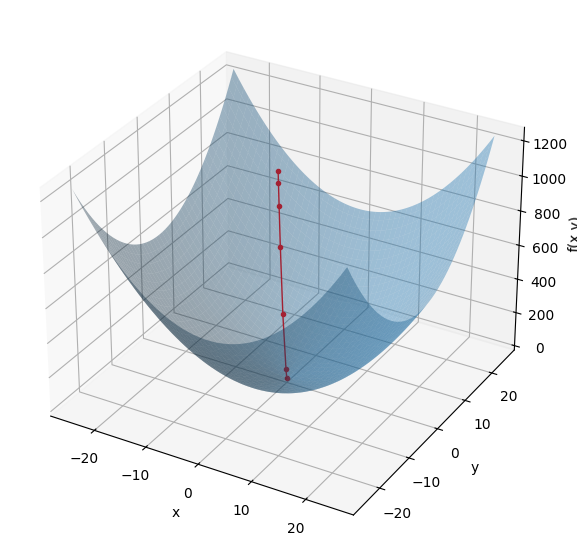

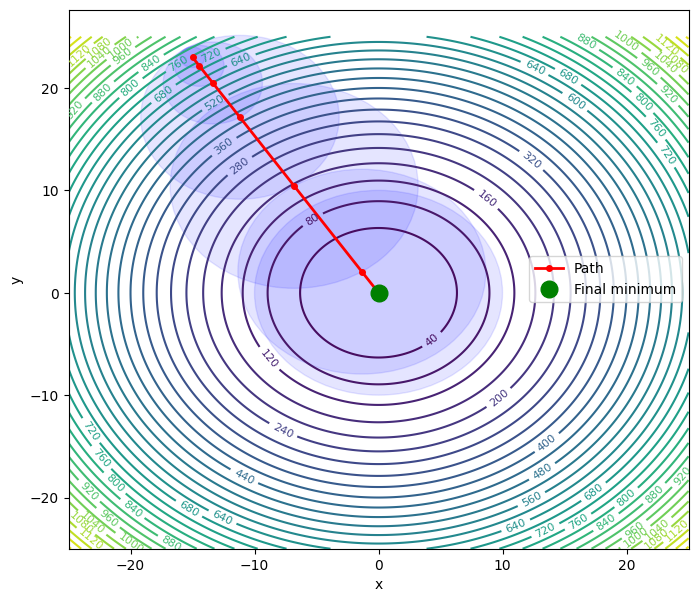

In [223]:
x_opt = trust_region(fun, derivative_fun, hessian_fun, x0=np.array([-15.0, 23.0]))

plot_3d(fun, x_opt["Path"], x_range= (-25, 25), y_range= (-25,25))
plot_trust_regions(fun, x_opt["Path"], x_opt["Regions"], x_range= (-25, 25), y_range= (-25,25))

x:  -0.5773502691896257 y:  2.101370248515171e-18


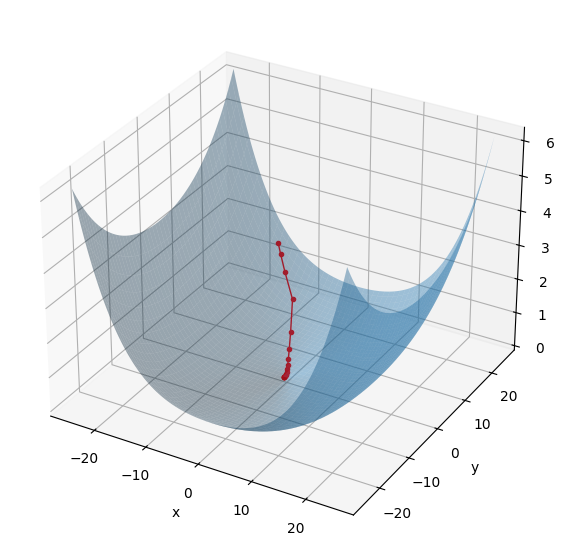

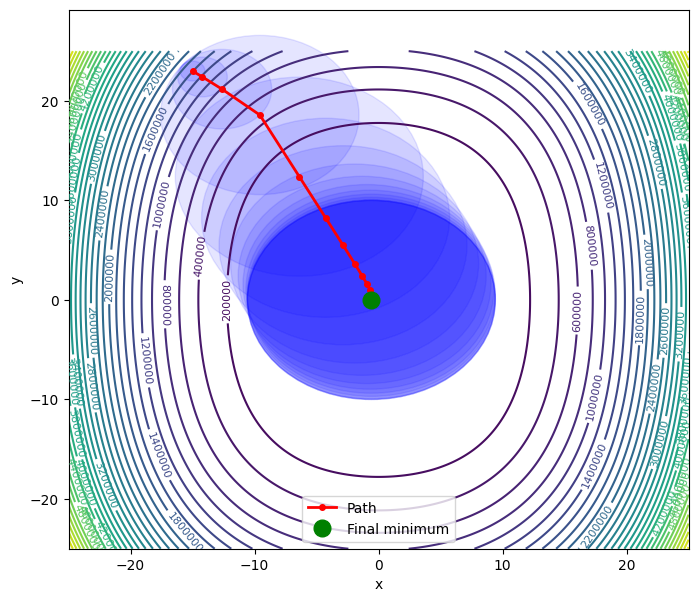

In [224]:
x_opt = trust_region(fun2, derivative_fun2, hessian_fun2, x0=np.array([-15.0, 23.0]))

plot_3d(fun2, x_opt["Path"], x_range= (-25, 25), y_range= (-25,25))
plot_trust_regions(fun2, x_opt["Path"], x_opt["Regions"], x_range= (-25, 25), y_range= (-25,25))

x:  0.0 y:  -7.278089259839364e-31


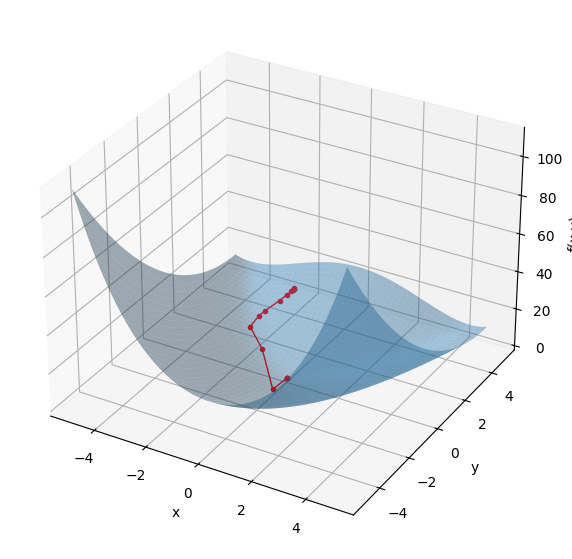

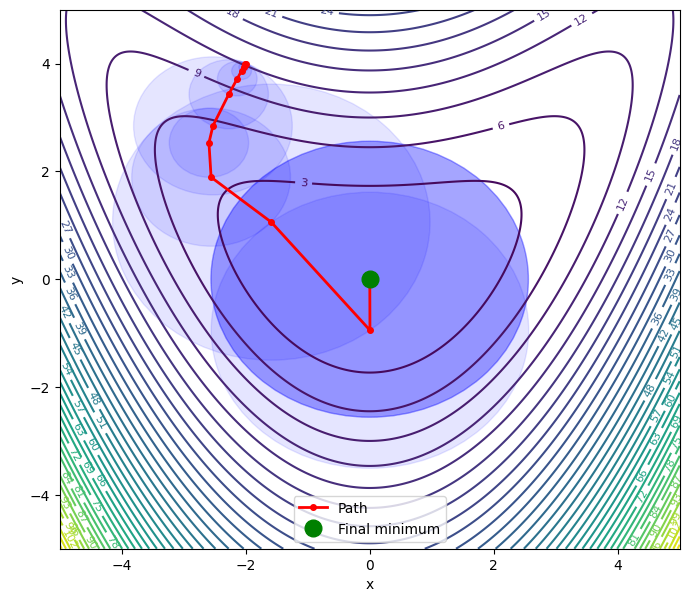

In [225]:
x_opt = trust_region(fun3, derivative_fun3, hessian_fun3, x0=np.array([-2.0, 4.0]), delta0= 0.01)

plot_3d(fun3, x_opt["Path"], x_range= (-5, 5), y_range= (-5,5))
plot_trust_regions(fun3, x_opt["Path"], x_opt["Regions"], x_range= (-5, 5), y_range= (-5,5))